# Roche Data Science — Home Study Case

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import joblib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

**Workflow:**

1. Data Exploration: Load the dataset and perform exploratory data analysis (EDA) to understand the distribution of variables, missing values, and potential correlations.
2. Data Preprocessing: Clean the data, handle missing values, encode categorical variables, and normalize/standardize numerical variables.
3. Model Selection: Choose several machine learning algorithms suitable for binary classification problems, such as Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machines.
4. Model Training and Evaluation: Train each model on the dataset, perform cross-validation, and evaluate them using appropriate metrics (accuracy, precision, recall, F1-score, ROC AUC).
4. Model Comparison: Compare the performance of the models to select the best one, based on the evaluation metrics.

## Step 1: Data Exploration

In [2]:
# Load the dataset
stroke_data = pd.read_csv('Stroke_Prediction.csv')

# Display the first few rows of the dataframe
print(stroke_data.head())

# Check for missing values
print(stroke_data.isnull().sum())

# Summary statistics for the numerical variables
print(stroke_data.describe())

# Distribution of the target variable
print(stroke_data['Stroke'].value_counts())

      ID  Gender  Age_In_Days  Hypertension  Heart_Disease Ever_Married  \
0  31153    Male       1104.0             0              0           No   
1  30650    Male      21204.0             1              0          Yes   
2  17412  Female       2928.0             0              0           No   
3  57008  Female      25578.0             0              0          Yes   
4  46657    Male       5128.0             0              0           No   

   Type_Of_Work Residence  Avg_Glucose   BMI   Smoking_Status  Stroke  
0      children     Rural        95.12  18.0              NaN       0  
1       Private     Urban        87.96  39.2     never smoked       0  
2       Private     Urban       110.89  17.6              NaN       0  
3       Private     Rural        69.04  35.9  formerly smoked       0  
4  Never_worked     Rural       161.28  19.1              NaN       0  
ID                    0
Gender                0
Age_In_Days           0
Hypertension          0
Heart_Disease        

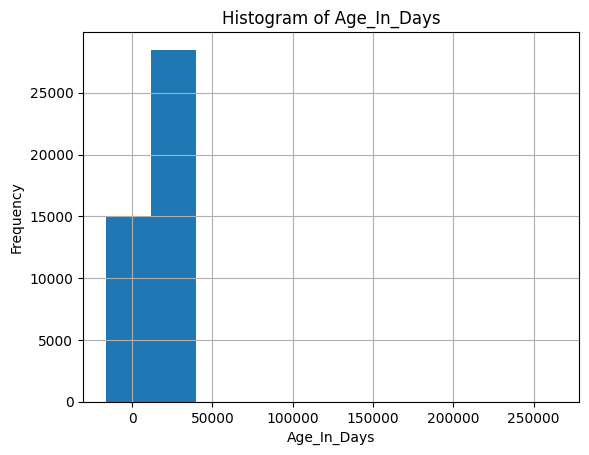

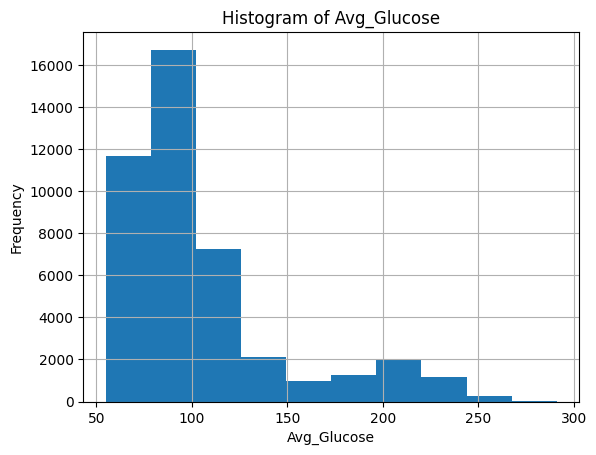

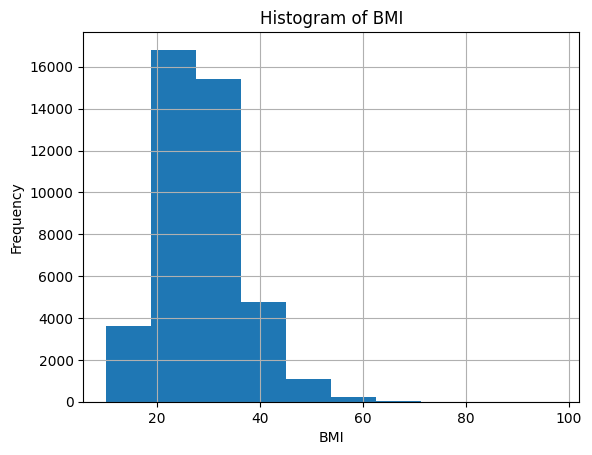

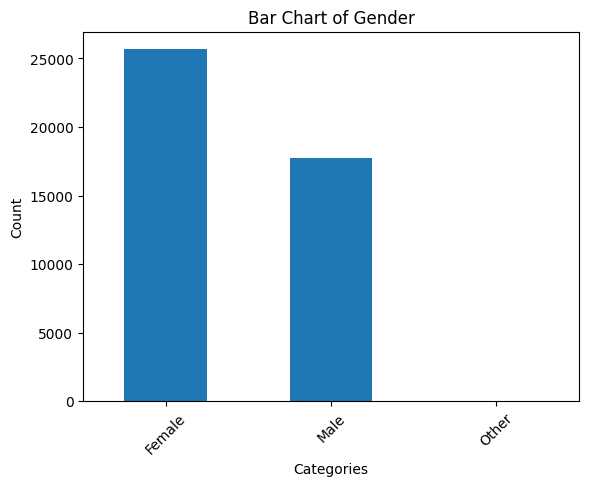

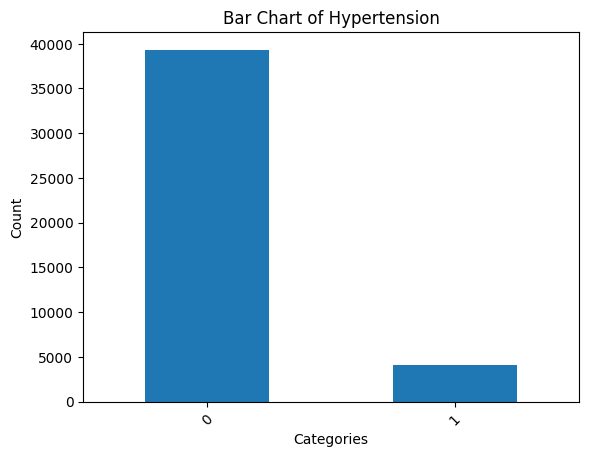

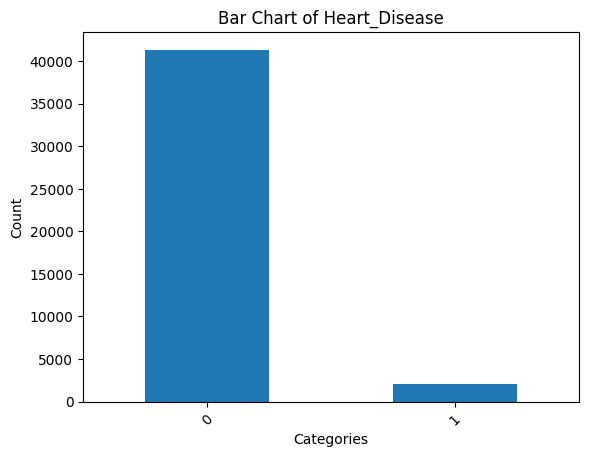

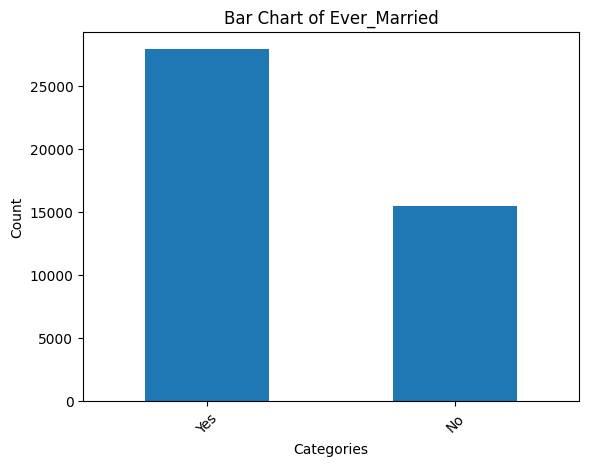

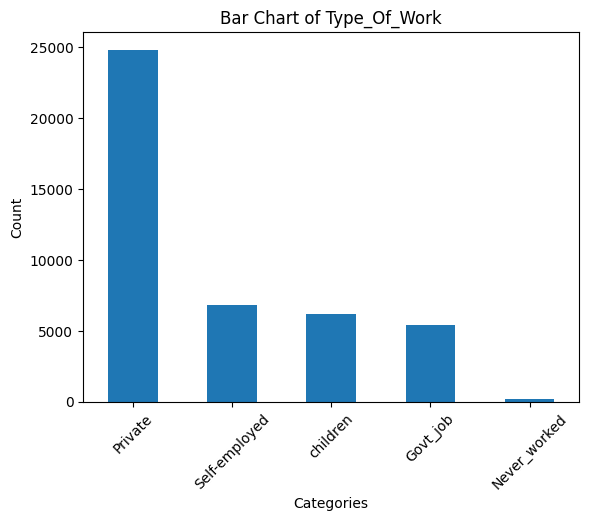

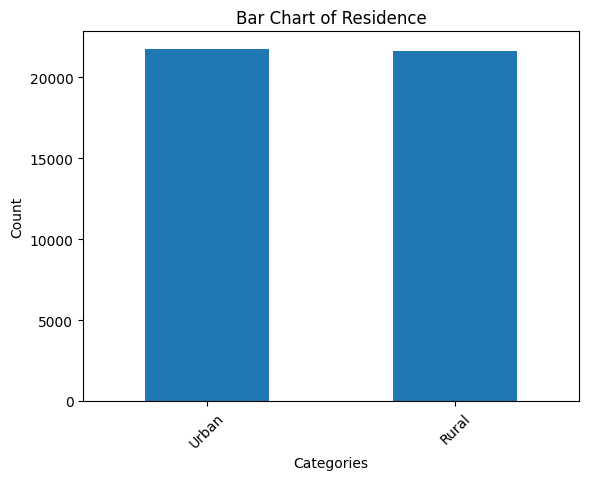

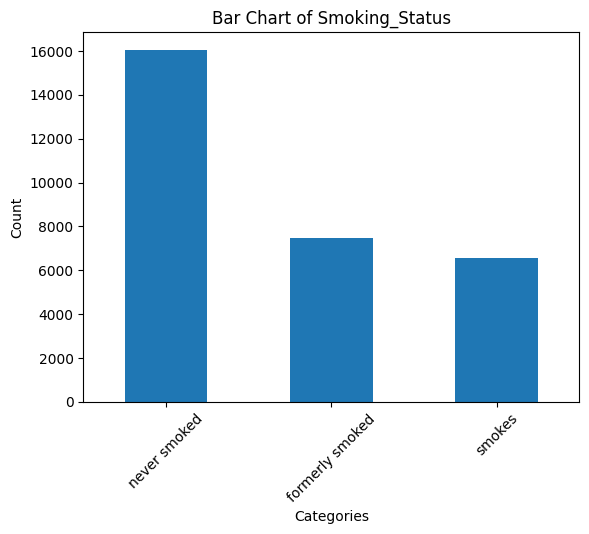

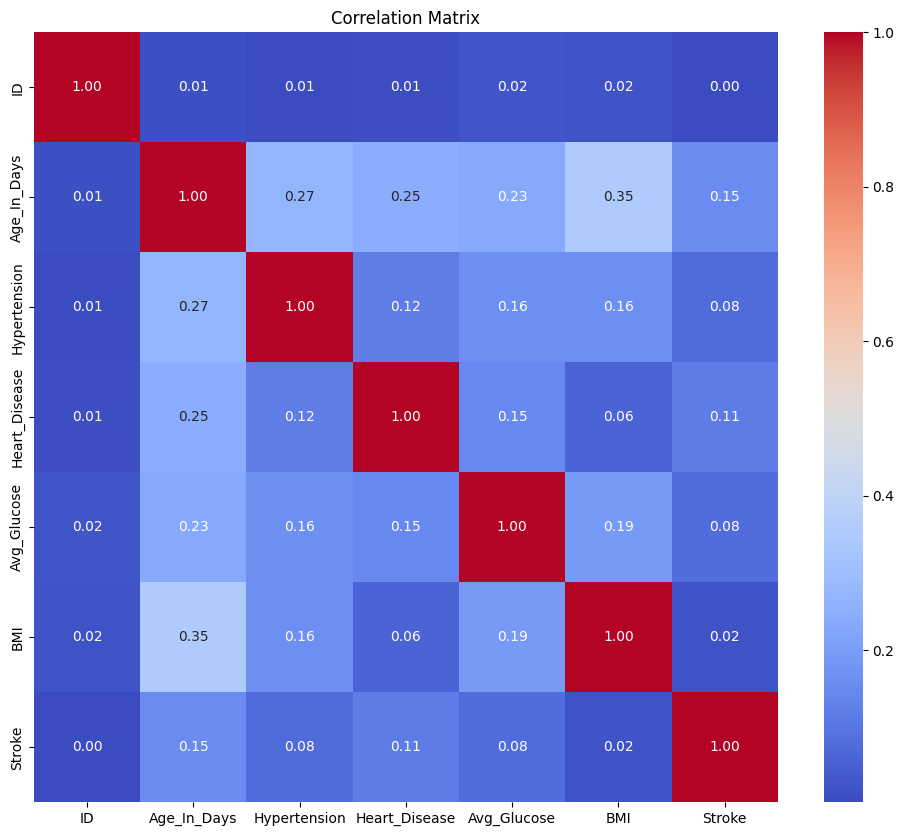

In [3]:
# Histograms for numerical variables
for col in ['Age_In_Days', 'Avg_Glucose', 'BMI']:
    stroke_data[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Bar charts for categorical variables
for col in ['Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married', 'Type_Of_Work', 'Residence', 'Smoking_Status']:
    stroke_data[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart of {col}')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels to prevent overlap
    plt.show()

# Select only numeric data for correlation matrix
numeric_cols = stroke_data.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = stroke_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The initial data exploration has revealed the following insights:

- The dataset contains 43,400 records and several features including `ID`, `Gender`, `Age_In_Days`, `Hypertension`, `Heart_Disease`, `Ever_Married`, `Type_Of_Work`, `Residence`, `Avg_Glucose`, `BMI`, `Smoking_Status`, and the target variable `Stroke`.
- There are missing values in two columns: BMI (1,462 missing values) and Smoking_Status (13,292 missing values).
- The numerical variables have a wide range of values, for example, `Age_In_Days` ranges from a negative number (which seems to be an error) to 264,301 days (which is over 720 years, clearly another data error). This indicates that data cleaning and validation will be essential steps.
- The target variable `Stroke` is imbalanced with only 783 (approximately 1.8%) positive cases (patients who have had a stroke) compared to 42,617 negative cases (patients who have not had a stroke).

## Step 2: Data Preprocessing

In [4]:
# Data Cleaning
# Remove invalid age entries
stroke_data = stroke_data[stroke_data['Age_In_Days'] > 0]

# K-NN imputation
knn_imputer = KNNImputer(n_neighbors=5)
stroke_data[['BMI']] = knn_imputer.fit_transform(stroke_data[['BMI']])

# Replace NaN values with a new category 'Unknown'
stroke_data['Smoking_Status'] = stroke_data['Smoking_Status'].fillna('Unknown')

# Encode categorical variables
categorical_cols = ['Gender', 'Ever_Married', 'Type_Of_Work', 'Residence', 'Smoking_Status']
one_hot_encoder = OneHotEncoder()
encoded_categorical = one_hot_encoder.fit_transform(stroke_data[categorical_cols]).toarray()

# Extract encoded categorical variable names
encoded_cat_feature_names = one_hot_encoder.get_feature_names_out(categorical_cols)

# Add encoded categorical features to the dataframe and remove original columns
stroke_data_encoded = pd.DataFrame(encoded_categorical, columns=encoded_cat_feature_names)
stroke_data = pd.concat([stroke_data.reset_index(drop=True), stroke_data_encoded], axis=1)
stroke_data.drop(columns=categorical_cols, inplace=True)

# Normalize numerical variables (excluding ID and Stroke)
numerical_cols = ['Age_In_Days', 'Avg_Glucose', 'BMI']
scaler = StandardScaler()
stroke_data[numerical_cols] = scaler.fit_transform(stroke_data[numerical_cols])

# Handling Class Imbalance
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(stroke_data.drop(columns=['Stroke', 'ID']), stroke_data['Stroke'])

# We now have X_smote and y_smote ready for model training

## Step 3: Model Selection

We will select a few machine learning algorithms that are commonly used for binary classification problems:

- Logistic Regression: A baseline model for binary classification problems.
- Random Forest: An ensemble method that can handle a large number of features and is less likely to overfit than decision trees.
- Gradient Boosting (e.g., XGBoost): An ensemble boosting method that can provide high accuracy if properly tuned.
- Support Vector Machine (SVM): Effective in high-dimensional spaces, which can be the case after encoding categorical variables.

## Step 4: Model Training and Evaluation

In [5]:
# Use SMOTE-adjusted data for splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Scale the features (necessary for L1 feature selection)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Logistic Regression with Cross-Validation and L1 penalty to perform feature selection
l1_logistic = LogisticRegressionCV(
    Cs=[0.1, 1, 10],
    cv=3,  # Reduce the number of folds for cross-validation
    penalty='l1',
    solver='saga',
    max_iter=10000,
    random_state=42,
    n_jobs=-1
).fit(X_train_scaled, y_train)

# Identify non-zero coefficients (i.e., selected features)
selected_features = np.flatnonzero(l1_logistic.coef_.sum(axis=0))

print(f"Number of features before selection: {X_train_scaled.shape[1]}")
print(f"Number of features after selection: {len(selected_features)}")

# Update X_train_scaled and X_test_scaled to only include selected features
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

# Define the pipelines that include the classifier
pipelines = {
    'LogisticRegression': Pipeline([
        ('classifier', LogisticRegression(solver='saga', max_iter=10000, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    'SVM': Pipeline([
        ('classifier', SVC(probability=True, random_state=42))
    ])
}

# Function to train and evaluate models with pipelines
def train_evaluate_with_pipeline(pipelines, X_train, y_train, X_test, y_test):
    for name, pipeline in pipelines.items():
        # Train the pipeline
        pipeline.fit(X_train, y_train)
        
        # Predict on the test set using the pipeline
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline['classifier'], "predict_proba") else pipeline.decision_function(X_test)
        
        # Evaluation metrics
        print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")
        print(f"{name} ROC AUC: {roc_auc_score(y_test, y_pred_proba)}\n")

# Evaluate the models with pipeline
train_evaluate_with_pipeline(pipelines, X_train_selected, y_train, X_test_selected, y_test)

Number of features before selection: 21
Number of features after selection: 19
LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8524
           1       0.76      0.84      0.80      8523

    accuracy                           0.79     17047
   macro avg       0.79      0.79      0.79     17047
weighted avg       0.79      0.79      0.79     17047

LogisticRegression ROC AUC: 0.8584182018204198

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8524
           1       0.95      0.98      0.97      8523

    accuracy                           0.97     17047
   macro avg       0.97      0.97      0.97     17047
weighted avg       0.97      0.97      0.97     17047

RandomForest ROC AUC: 0.9947303822989693

XGBoost Classification Report:
              precision    recall  f1-score   support

           0 

The Random Forest and XGBoost models are performing exceptionally well with high scores in all metrics. We will refine them and incorporate ensemble methods to further improve the model performance.

## Step 5: Model Selection and Refinement

### 5.1 Hyperparameter Tuning for Random Forest

In [6]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                              cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_rf.fit(X_train_selected, y_train)

# Print the best parameters
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.6s
[CV] END max_depth=10, min_sa

### 5.2 Hyperparameter Tuning for XGBoost

In [7]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize the classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform grid search
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, 
                               cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_xgb.fit(X_train_selected, y_train)

# Print the best parameters
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   6.3

### 5.3 Model Ensembling

In [8]:
# Define the base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=grid_search_rf.best_params_['n_estimators'],
                                  max_depth=grid_search_rf.best_params_['max_depth'],
                                  min_samples_split=grid_search_rf.best_params_['min_samples_split'],
                                  min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
                                  random_state=42)),
    ('xgb', XGBClassifier(n_estimators=grid_search_xgb.best_params_['n_estimators'],
                          max_depth=grid_search_xgb.best_params_['max_depth'],
                          learning_rate=grid_search_xgb.best_params_['learning_rate'],
                          subsample=grid_search_xgb.best_params_['subsample'],
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42))
]

# Initialize the stacking classifier
stacked_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=3)

# Fit the model on the training data
stacked_model.fit(X_train_selected, y_train)

StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              gpu_id=None, gr...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.2, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...))],
                   final_estimator=RandomForestClassifier())

<Figure size 1000x800 with 0 Axes>

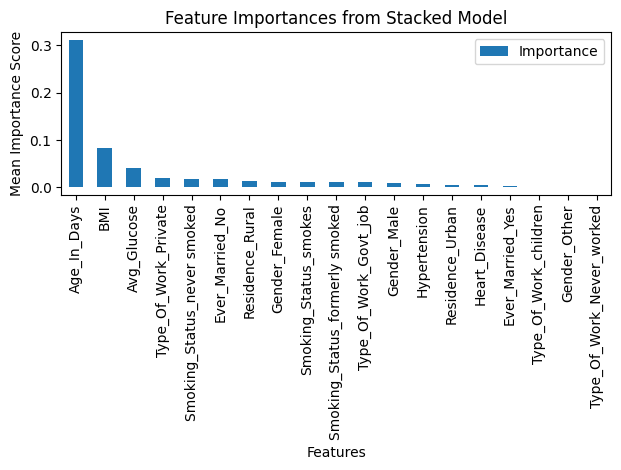

In [16]:
# `X_smote` is a DataFrame with column names before any scaling or feature selection
original_feature_names = X_smote.columns

# Perform permutation importance using the selected features on the test set
results = permutation_importance(stacked_model, X_test_selected, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the mean importance scores
importances = results.importances_mean

# Use the selected_features indices to extract the corresponding feature names from the original dataset
selected_feature_names = original_feature_names[selected_features]

# Create a DataFrame with the feature importances
importances_df = pd.DataFrame(importances, index=selected_feature_names, columns=["Importance"])

# Sort the DataFrame by the importance scores
sorted_importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(10, 8))
sorted_importances_df.plot(kind='bar')
plt.title('Feature Importances from Stacked Model')
plt.ylabel('Mean Importance Score')
plt.xlabel('Features')
plt.tight_layout()  # Adjust layout for better fit of labels
plt.show()

## Step 6: Model Evaluation

### 6.1 Evaluating the Tuned Models on the Test Set

In [17]:
# Predict on the test set using the stacked model
y_pred_stacked = stacked_model.predict(X_test_selected)
y_pred_proba_stacked = stacked_model.predict_proba(X_test_selected)[:, 1]

# Evaluation metrics for the stacked model
print(f"Stacked Model Classification Report:\n{classification_report(y_test, y_pred_stacked)}")
print(f"Stacked Model ROC AUC: {roc_auc_score(y_test, y_pred_proba_stacked)}\n")

Stacked Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8524
           1       0.98      0.97      0.98      8523

    accuracy                           0.98     17047
   macro avg       0.98      0.98      0.98     17047
weighted avg       0.98      0.98      0.98     17047

Stacked Model ROC AUC: 0.9955603335287357



### 6.2 Confusion Matrix and ROC Curve Visualization

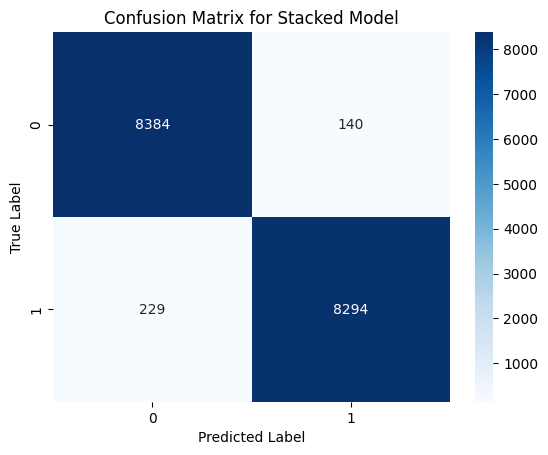

In [19]:
# Confusion matrix for the stacked model
conf_matrix_stacked = confusion_matrix(y_test, y_pred_stacked)
sns.heatmap(conf_matrix_stacked, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacked Model')
plt.show()

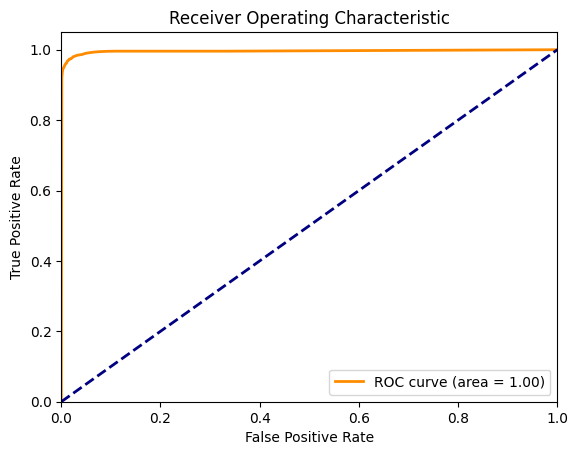

In [20]:
# ROC curve for the stacked model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_stacked)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Step 7: Saving and Loading the Model

In [21]:
# Save the scaler, one-hot encoder, and model to a file
joblib.dump(stacked_model, 'stacked_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(one_hot_encoder, 'encoder.joblib')

['encoder.joblib']

In [22]:
# Load the scaler, one-hot encoder, and model from the file
loaded_scaler = joblib.load('scaler.joblib')
loaded_encoder = joblib.load('encoder.joblib')
loaded_stacked_model = joblib.load('stacked_model.joblib')

# We can use loaded_stacked_model to make predictions etc.